# BrainHack 2024 Project

This jupyter notebook was created in the context of the **BrainHack school 2024** at Polytechnique Montréal, specifically the *"Classifiers"* portion of my project. 

It will allow **training and testing of three different classifiers** as well as their **performance comparison** on individual participants. As the original classifier's accuracy was around 50%, efforts were put into making movement decoding more robust. 

## Importing libraries and modules

In [1]:
import os, requests
import numpy as np
import plotly.graph_objs as go
import pandas as pd
import plotly.io as pio
from scipy import signal
from matplotlib import colors, pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.feature_selection import RFE, SelectFromModel

## Importing and loading dataset

This section was not modified from https://github.com/Xianhui-He/Raclette-Group-2-ECoG-Motor-Imagery/tree/main

In [2]:
fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
          
alldat = np.load(fname, allow_pickle=True)['dat']

## Selecting specific electrodes

This section was not modified from https://github.com/Xianhui-He/Raclette-Group-2-ECoG-Motor-Imagery/tree/main

In [3]:
electrode_indexes = []
electrode_indexes.append([])
electrode_indexes.append([])

for subject_index, subject in enumerate(alldat):
  electrode_indexes[0].append([])
  electrode_indexes[1].append([])
  for gyrus_index, gyrus in enumerate(subject[0]['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes[0][subject_index].append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes[1][subject_index].append(gyrus_index)

## Data processing

In [4]:
def get_data_label_allroi(sub_ID, condi_ID, time_ID, band_limit):
  # Input:
    # sub_ID: 0-6
    # condi_ID: 0 refers to actual movement, 1 refers to imagery movement
    # time_ID: 0 refers to the first second, 1 refers to the sencond second
    # band_limit: band pass filter parameters, for example, input [8, 12] to obtain alpha power

  # output:
    # data: n_trials * n_features power matrix
    # label: n_trials label array

  dat = alldat[sub_ID][condi_ID] 
  ele_used = np.concatenate((electrode_indexes[0][sub_ID],electrode_indexes[1][sub_ID]), axis=0)
    
  # filter the data
    
  # V is the voltage data
  V = dat['V'].astype('float32')
  V = V[:, ele_used]

  # band-pass filter below band_limit[1] Hz
  b, a = signal.butter(3, band_limit, btype='bandpass', fs=1000) #this was the only line changed from the original code
  V = signal.filtfilt(b, a, V, 0)

  # calculate the power (hilbert)
  V_tmp = signal.hilbert(V) 
  V = np.abs(V_tmp) ** 2

  # data reconstruction into different epochs 
  nt, nchan = V.shape
  nstim = len(dat['t_on'])
  trange = np.arange(0, 2000)
  ts = dat['t_on'][:, np.newaxis]
  ts = ts + trange
  V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

  # average every 20 ms to obtain 50 time points for each channel
  data = np.empty((nstim,0),int)
  for it in range(50):
    V_epochs_tmp = V_epochs[:, [it * 20 + time_ID * 1000, (it + 1) * 20 - 1 + time_ID * 1000], :]
    data_tmp = np.mean(V_epochs_tmp, 1)
    data = np.hstack((data, data_tmp))
  label = dat['stim_id']

  return data, label

## Defining plotting function

In [5]:
def plot_classifier_performance(test_set_acc, num_subjects, condition_name, condition_idx, color, file_name):
    x_indices = np.arange(num_subjects)  
    bar_width = 0.35  
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    ax.set_title(f"Classifier Performance for {condition_name} Condition (Time 2)")
    positions = x_indices  

    # Calculate mean and standard error for the condition at Time 2
    y_condition = np.mean(test_set_acc[:, condition_idx])
    yerr_condition = np.std(test_set_acc[:, condition_idx]) * 1.96 / np.sqrt(num_subjects)

    # Plot bars for individual subjects for the condition at Time 2
    for isub in range(num_subjects):
        ax.bar(positions[isub], test_set_acc[isub, condition_idx], color=color, 
               width=bar_width, alpha=0.7, edgecolor='k')

    ax.set_xticks(x_indices)
    ax.set_xticklabels([f'Subj {i + 1}' for i in range(num_subjects)])
    ax.set(
        yticks=[0, 0.25, 0.5, 0.75, 1],
        ylabel='Accuracy',
        ylim=(0, 1)
    )
    plt.hlines(0.5, -0.5, num_subjects, colors='k', linestyles='dashed')
    plt.legend(loc='upper right')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(file_name) 
    plt.show()

# Classifiers:

## Classifier 1: Unmodified SVM

Gneral Description: 

This classifier was taken from the Raclette Group 2 during their project in Neuromatch Academy computational neuroscience. 
It consists of an SVM (support vector machine) with a linear kernel and a C parameter equal to 1. 

Modifications: 

The original classifier code only (https://github.com/Xianhui-He/Raclette-Group-2-ECoG-Motor-Imagery/tree/main) presented training scores, cross-validation scores and generalization to the other condition scores (actual vs imagined movement). It has been adapted to show testing scores on data from the same condition.  

In [12]:
def train_orig_svm_fixed_split(sub_ID, condi_ID, time_ID, band_limit, test_indices):
    # Load data and labels
    data, label = get_data_label_allroi(sub_ID, condi_ID, time_ID, band_limit)
    
    # Define training indices by excluding test indices
    train_indices = [i for i in range(len(data)) if i not in test_indices]
    
    # Split data into training and test sets using predefined indices
    data_train = data[train_indices]
    label_train = label[train_indices]
    data_test = data[test_indices]
    label_test = label[test_indices]

    # Arrays to store accuracies for each trial in LOO
    test_accuracies = np.ones(len(data_train))
    train_accuracies = np.ones(len(data_train))
    
    # Leave-One-Out Cross-Validation on training data
    loo = LeaveOneOut()
    loo.get_n_splits(data_train)

    for train_index, test_index in loo.split(data_train):
        classifier = svm.SVC(C=1, kernel='linear')
        classifier.fit(data_train[train_index], label_train[train_index])
        
        train_accuracies[test_index] = classifier.score(data_train[train_index], label_train[train_index])
        test_accuracies[test_index] = classifier.score(data_train[test_index], label_train[test_index])

    # Train final classifier on the entire training set
    classifier_final = svm.SVC(C=1, kernel='linear')
    classifier_final.fit(data_train, label_train)

    # Evaluate on the separate test set
    test_set_accuracy = classifier_final.score(data_test, label_test)

    # Generalization to another condition
    gen_data, gen_label = get_data_label_allroi(sub_ID, 1 - condi_ID, time_ID, band_limit)
    gen_acc = classifier_final.score(gen_data, gen_label)

    return test_accuracies.mean(), train_accuracies.mean(), test_set_accuracy, gen_acc

## Plotting individual performances

In [13]:
total_samples = len(get_data_label_allroi(0, 0, 1, [13, 30])[0])  # Time ID = 1 for Time 2
fixed_test_indices = list(range(int(0.8 * total_samples), total_samples))

# Initialize arrays to store results
band_limit = [13, 30]  # Example frequency band
num_subjects = 7  # Example number of subjects

test_set_acc = np.zeros((num_subjects, 2))  # Store test accuracies for 2 conditions (actual, imagery)

for isub in range(num_subjects):
    for icondi in range(2):  # 0: Actual, 1: Imagined
        avg_test_acc, avg_train_acc, test_acc, gen_acc = train_orig_svm_fixed_split(isub, icondi, 1, band_limit, fixed_test_indices)
        test_set_acc[isub, icondi] = test_acc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


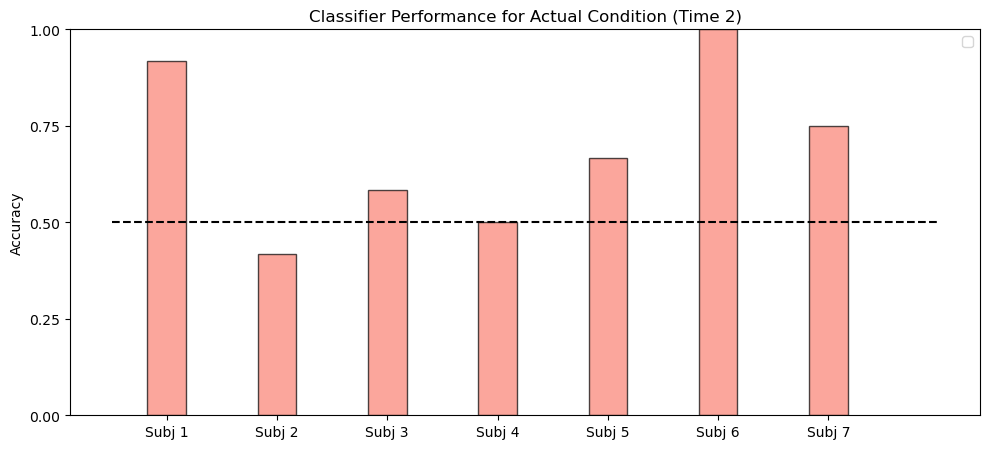

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


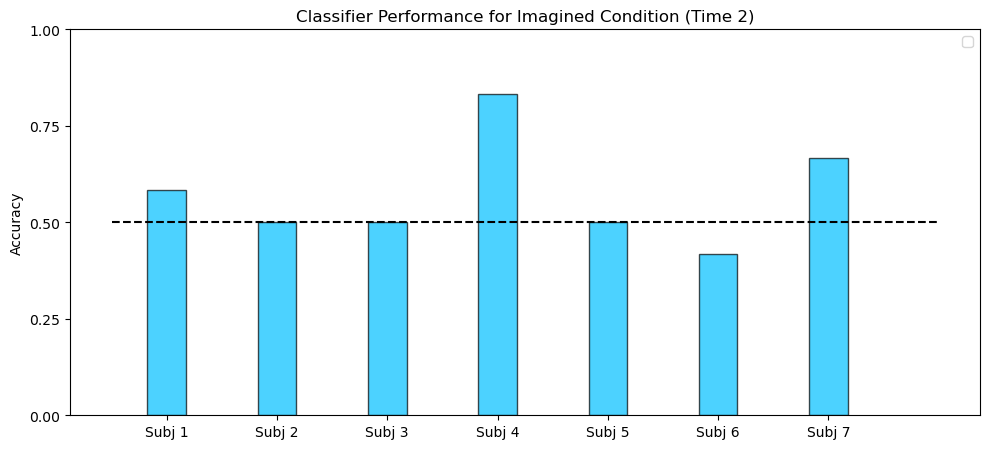

In [14]:
# Plot for Actual Condition
plot_classifier_performance(test_set_acc, num_subjects, "Actual", 0, 'salmon', "Actual_Condition_Time2.png")
# Plot for Imagined Condition
plot_classifier_performance(test_set_acc, num_subjects, "Imagined", 1, 'deepskyblue', "Imagined_Condition_Time2.png")

## Classifier 2: Modified SVM

General Description:

Modifications:
1. Data Standardization, using StandardScaler(), by removing the mean and scaling to unit variance
2. Feature Selection with RFE (recursive feature elimination) using RFE()

In [15]:
def train_svm_fixed_split(sub_ID, condi_ID, time_ID, band_limit, test_indices):
    # Load data and labels
    data, label = get_data_label_allroi(sub_ID, condi_ID, time_ID, band_limit)

    # Standardize the data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Define training indices by excluding test indices
    train_indices = [i for i in range(len(data)) if i not in test_indices]

    # Split data into training and test sets using predefined indices
    data_train = data[train_indices]
    label_train = label[train_indices]
    data_test = data[test_indices]
    label_test = label[test_indices]

    loo_test_accuracies = []
    train_accuracies = np.zeros(len(data_train))
    
    # Leave-One-Out Cross-Validation on training data
    loo = LeaveOneOut()
    loo.get_n_splits(data_train)

    for train_index, val_index in loo.split(data_train):
        # Feature selection with RFE
        base_svc = SVC(kernel='linear', C=1)
        selector = RFE(base_svc, n_features_to_select=50, step=10)
        train_data = selector.fit_transform(data_train[train_index], label_train[train_index])
        val_data = selector.transform(data_train[val_index])

        # Train the classifier
        classifier = SVC(C=1, kernel='linear')
        classifier.fit(train_data, label_train[train_index])

        # Evaluate performance on the validation data
        val_acc = classifier.score(val_data, label_train[val_index])
        loo_test_accuracies.append(val_acc)
        
        # Store training accuracy
        train_accuracies[val_index] = classifier.score(train_data, label_train[train_index])

    avg_loo_test_acc = np.mean(loo_test_accuracies)

    # Train final classifier on the entire training set
    final_selector = RFE(SVC(kernel='linear', C=1), n_features_to_select=50, step=10)
    data_train_selected = final_selector.fit_transform(data_train, label_train)
    data_test_selected = final_selector.transform(data_test)

    classifier_final = SVC(C=1, kernel='linear')
    classifier_final.fit(data_train_selected, label_train)

    # Evaluate on the separate test set
    test_set_accuracy = classifier_final.score(data_test_selected, label_test)

    # Generalization to another condition
    gen_data, gen_label = get_data_label_allroi(sub_ID, 1 - condi_ID, time_ID, band_limit)
    gen_data = scaler.transform(gen_data)
    gen_data_selected = final_selector.transform(gen_data)
    gen_acc = classifier_final.score(gen_data_selected, gen_label)

    return avg_loo_test_acc, train_accuracies.mean(), test_set_accuracy, gen_acc

## Plotting individual performance

In [16]:
for isub in range(num_subjects):
    for icondi in range(2):  # 0: Actual, 1: Imagined
        avg_loo_test_acc, train_acc, test_acc, gen_acc = train_svm_fixed_split(isub, icondi, 1, band_limit, fixed_test_indices)
        test_set_acc[isub, icondi] = test_acc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


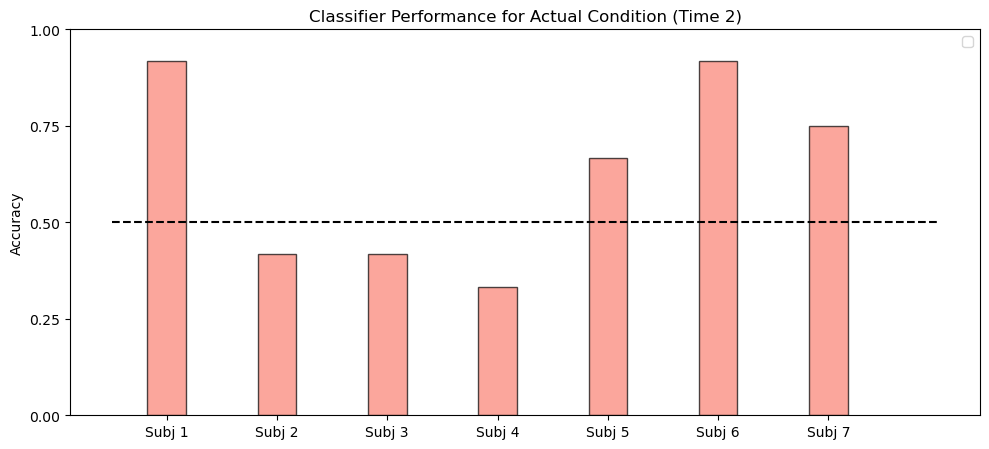

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


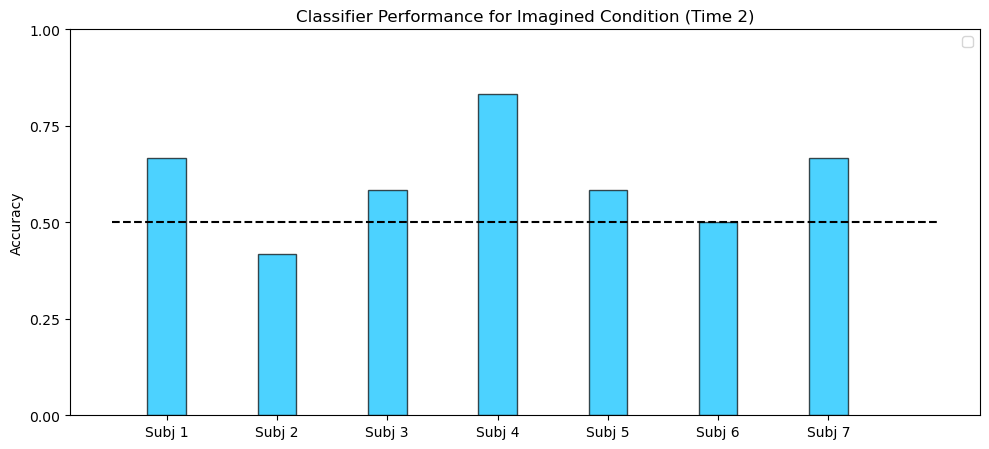

In [17]:
# Plot for Actual Condition
plot_classifier_performance(test_set_acc, num_subjects, "Actual", 0, 'salmon', "Actual_Condition_Time2.png")
# Plot for Imagined Condition
plot_classifier_performance(test_set_acc, num_subjects, "Imagined", 1, 'deepskyblue', "Imagined_Condition_Time2.png")

## Classifier 3: Random Forest Classifier

Description:

It's a Random Forest classifier with data standardization using StandardScaler( ) and feature selection using SelectFromModel( )

In [18]:
def train_rf_fixed_split(sub_ID, condi_ID, time_ID, band_limit, test_indices):
    # Load data and labels
    data, label = get_data_label_allroi(sub_ID, condi_ID, time_ID, band_limit)

    # Standardize the data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Define training indices by excluding test indices
    train_indices = [i for i in range(len(data)) if i not in test_indices]

    # Split data into training and test sets using predefined indices
    data_train = data[train_indices]
    label_train = label[train_indices]
    data_test = data[test_indices]
    label_test = label[test_indices]

    # Arrays to store accuracies for each trial in LOO
    loo_test_accuracies = []
    train_accuracies = np.zeros(len(data_train))
    
    # Leave-One-Out Cross-Validation on training data
    loo = LeaveOneOut()
    loo.get_n_splits(data_train)

    for train_index, val_index in loo.split(data_train):
        # Feature selection with SelectFromModel
        base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        selector = SelectFromModel(base_rf, threshold='median')
        train_data = selector.fit_transform(data_train[train_index], label_train[train_index])
        val_data = selector.transform(data_train[val_index])

        # Train the classifier
        classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        classifier.fit(train_data, label_train[train_index])

        # Evaluate performance on the validation data
        val_acc = classifier.score(val_data, label_train[val_index])
        loo_test_accuracies.append(val_acc)
        
        # Store training accuracy
        train_accuracies[val_index] = classifier.score(train_data, label_train[train_index])

    avg_loo_test_acc = np.mean(loo_test_accuracies)

    # Train final classifier on the entire training set
    final_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
    data_train_selected = final_selector.fit_transform(data_train, label_train)
    data_test_selected = final_selector.transform(data_test)

    classifier_final = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier_final.fit(data_train_selected, label_train)

    # Evaluate on the separate test set
    test_set_accuracy = classifier_final.score(data_test_selected, label_test)

    # Generalization to another condition
    gen_data, gen_label = get_data_label_allroi(sub_ID, 1 - condi_ID, time_ID, band_limit)
    gen_data = scaler.transform(gen_data)
    gen_data_selected = final_selector.transform(gen_data)
    gen_acc = classifier_final.score(gen_data_selected, gen_label)

    return avg_loo_test_acc, train_accuracies.mean(), test_set_accuracy, gen_acc


## Plotting individual performance

In [19]:
for isub in range(num_subjects):
    for icondi in range(2):  # 0: Actual, 1: Imagined
        avg_loo_test_acc, train_acc, test_acc, gen_acc = train_rf_fixed_split(isub, icondi, 1, band_limit, fixed_test_indices)
        test_set_acc[isub, icondi] = test_acc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


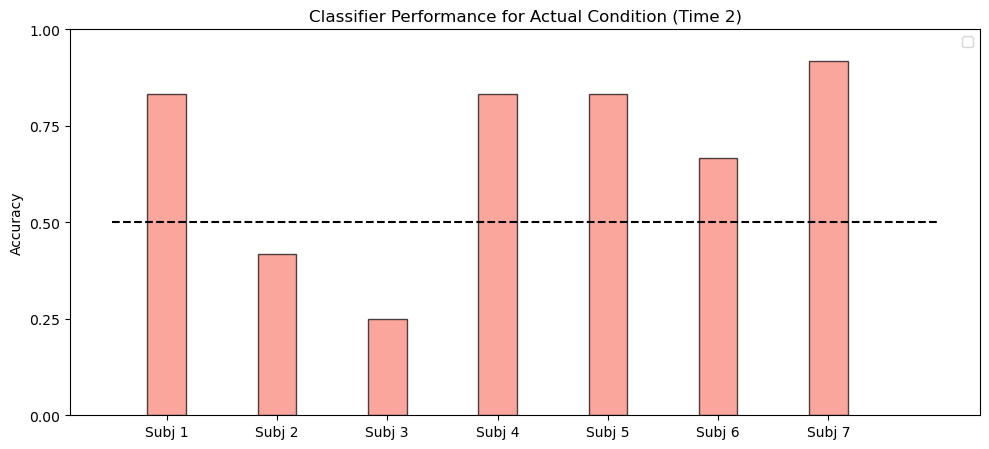

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


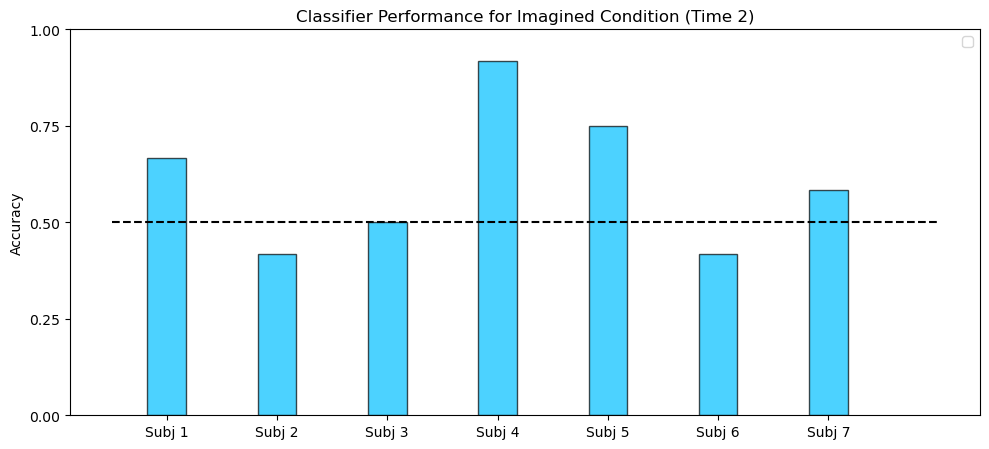

In [20]:
# Plot for Actual Condition
plot_classifier_performance(test_set_acc, num_subjects, "Actual", 0, 'salmon', "Actual_Condition_Time2.png")
# Plot for Imagined Condition
plot_classifier_performance(test_set_acc, num_subjects, "Imagined", 1, 'deepskyblue', "Imagined_Condition_Time2.png")

In [21]:
num_subjects = 7  # Adjust based on the actual number of subjects
band_limit = [8, 12]  # Frequency band
time_ID = 1  # Time ID for data extraction
fixed_test_indices = list(range(int(0.8 * len(get_data_label_allroi(0, 0, time_ID, band_limit)[0])), len(get_data_label_allroi(0, 0, time_ID, band_limit)[0])))

# Collect performance data for actual and imagined conditions
performance_data_actual = {'Subjects': []}
performance_data_imagined = {'Subjects': []}
classifier_names = ['SVM original', 'SVM RFE', 'Random Forest']

# Initialize arrays to store performance
test_set_acc_actual = np.zeros((num_subjects, len(classifier_names)))
test_set_acc_imagined = np.zeros((num_subjects, len(classifier_names)))

for isub in range(num_subjects):
    performance_data_actual['Subjects'].append(f'Subject_{isub+1}')
    performance_data_imagined['Subjects'].append(f'Subject_{isub+1}')
    for i, clf_name in enumerate(classifier_names):
        if clf_name == 'SVM original':
            _, _, test_acc_actual, _ = train_orig_svm_fixed_split(isub, 0, time_ID, band_limit, fixed_test_indices)
            _, _, test_acc_imagined, _ = train_orig_svm_fixed_split(isub, 1, time_ID, band_limit, fixed_test_indices)
        elif clf_name == 'SVM RFE':
            _, _, test_acc_actual, _ = train_svm_fixed_split(isub, 0, time_ID, band_limit, fixed_test_indices)
            _, _, test_acc_imagined, _ = train_svm_fixed_split(isub, 1, time_ID, band_limit, fixed_test_indices)
        elif clf_name == 'Random Forest':
            _, _, test_acc_actual, _ = train_rf_fixed_split(isub, 0, time_ID, band_limit, fixed_test_indices)
            _, _, test_acc_imagined, _ = train_rf_fixed_split(isub, 1, time_ID, band_limit, fixed_test_indices)
        
        test_set_acc_actual[isub, i] = test_acc_actual
        test_set_acc_imagined[isub, i] = test_acc_imagined

# Convert to DataFrames for easier plotting
performance_df_actual = pd.DataFrame(test_set_acc_actual, index=performance_data_actual['Subjects'], columns=classifier_names)
performance_df_imagined = pd.DataFrame(test_set_acc_imagined, index=performance_data_imagined['Subjects'], columns=classifier_names)


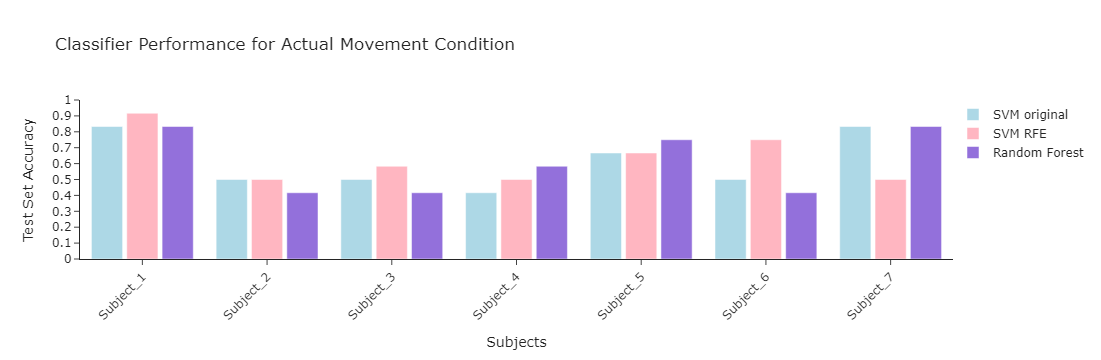

gio: file:///home/jabdo/abdo_project/neuromatch_project/Raclette-Group-2-ECoG-Motor-Imagery/code/Actual_Movement_Condition.html: Failed to find default application for content type ‘text/html’


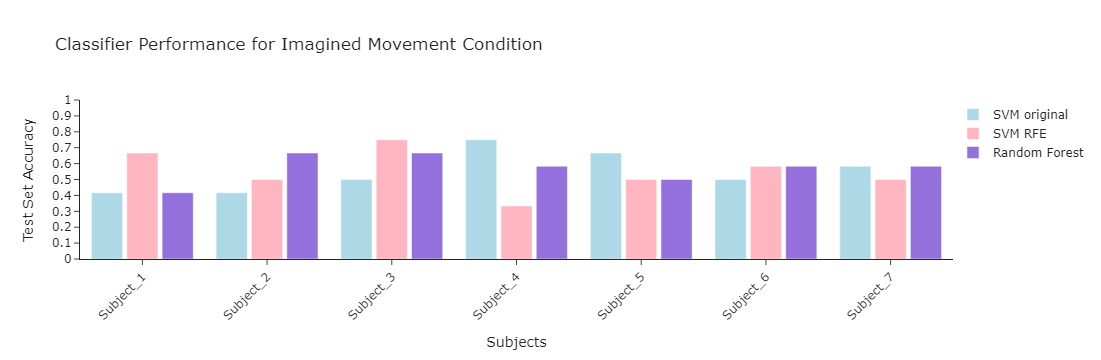

gio: file:///home/jabdo/abdo_project/neuromatch_project/Raclette-Group-2-ECoG-Motor-Imagery/code/Imagined_Movement_Condition.html: Failed to find default application for content type ‘text/html’


In [25]:
num_subjects = performance_df_actual.shape[0]  # Replace with the actual number of subjects
# Plot for Actual Movement Condition
fig_actual = go.Figure()
bar_width = 0.25
x_indices = np.arange(num_subjects)
colors = ['lightblue', 'lightpink', 'mediumpurple']

for i, classifier in enumerate(performance_df_actual.columns):
    fig_actual.add_trace(go.Bar(
        x=performance_df_actual.index,
        y=performance_df_actual[classifier],
        name=classifier,
        marker_color=colors[i],
        width=bar_width
    ))

fig_actual.update_layout(
    title='Classifier Performance for Actual Movement Condition',
    xaxis_title='Subjects',
    yaxis_title='Test Set Accuracy',
    yaxis=dict(range=[0, 1], tickvals=np.arange(0, 1.1, 0.1)),
    xaxis=dict(tickangle=-45),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1,
    template='simple_white',
    legend=dict(x=1, y=1)
)

fig_actual.show()
pio.write_html(fig_actual, file='Actual_Movement_Condition.html', auto_open=True)

# Plot for Imagined Movement Condition
fig_imagined = go.Figure()
for i, classifier in enumerate(performance_df_imagined.columns):
    fig_imagined.add_trace(go.Bar(
        x=performance_df_imagined.index,
        y=performance_df_imagined[classifier],
        name=classifier,
        marker_color=colors[i],
        width=bar_width
    ))

fig_imagined.update_layout(
    title='Classifier Performance for Imagined Movement Condition',
    xaxis_title='Subjects',
    yaxis_title='Test Set Accuracy',
    yaxis=dict(range=[0, 1], tickvals=np.arange(0, 1.1, 0.1)),
    xaxis=dict(tickangle=-45),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1,
    template ='simple_white',
    legend=dict(x=1, y=1)
)
fig_imagined.show()
pio.write_html(fig_imagined, file='Imagined_Movement_Condition.html', auto_open=True)